In [1]:
import dask.dataframe as dd
import os
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import re
import itertools

In [2]:
#import network files
os.chdir('/scratch/bacint/jdeleuw/ananse/network_data')
Day0 = dd.read_csv(os.getcwd() + '/Day0_network.txt', sep='\t|_', engine='python')
Day07 = dd.read_csv(os.getcwd() + '/Day07_network.txt', sep='\t|_', engine='python')
Day14 = dd.read_csv(os.getcwd() + '/Day14_network.txt', sep='\t|_', engine='python')
Day21 = dd.read_csv(os.getcwd() + '/Day21_network.txt', sep='\t|_', engine='python')
Day43 = dd.read_csv(os.getcwd() + '/Day43_network.txt', sep='\t|_', engine='python')
Day60 = dd.read_csv(os.getcwd() + '/Day60_network.txt', sep='\t|_', engine='python')
KC = dd.read_csv(os.getcwd() + '/KC_network.txt', sep='\t|_', engine='python')

In [3]:
Interesting_TFs = pd.read_csv('/scratch/bacint/jdeleuw/ananse/analysis/interesting_TFs.csv', header = None)

In [4]:
Cluster1 = ['ZSCAN10', 'ZIC3', 'SOX2', 'PRDM14', 'SALL4', 'OTX2', 'NANOG', 'FOXH1', 'MYBL2']
Cluster2 = ['HAND1', 'MEIS1', 'HOXB2', 'MEIS2', 'MSX2', 'TBX3', 'HEY1', 'TFAP2B']
Cluster3 = ['TP63', 'IRX3', 'NFIC', 'HES2', 'EHF']
Cluster4 = ['TFAP2A', 'GRHL1', 'IRF6', 'KLF5', 'SNAI2', 'EPAS1', 'CEBPD', 'FOSL2']

In [ ]:
#filter the TFs of of all the clusters from the network files
TFs = Cluster1 + Cluster2 + Cluster3 + Cluster4
ddf_networks = [Day0, Day07, Day14, Day21, Day43, Day60, KC]
output_names = ['filtered_' + i for i in dir() if i.startswith('Day')] + ['filtered_KC']

for ddf_network, output_name in zip(ddf_networks, output_names): 
    filter1 = ddf_network.source.isin(TFs)
    filter2 = ddf_network.target.isin(TFs)
    filtered_network = ddf_network[filter1 & filter2]
    globals()[output_name] = filtered_network.compute().reset_index(drop = True)

In [6]:
source = Cluster1 + Cluster2 + Cluster3 + Cluster4 
target = Cluster1 + Cluster2 + Cluster3 + Cluster4 

temp = '_Cluster1 + Cluster2 + Cluster3 + Cluster4 '
names = temp.replace(' + ', '_')

In [137]:
#filter the interesting TFs from the network files
filter1 = filtered_Day43.source.isin(source)
filter2 = filtered_Day43.target.isin(target)
res_network = filtered_Day43[filter1 & filter2].reset_index(drop = True)

In [138]:
#filter rows with specified binding and probability score
result_network = res_network.copy()
bind_prob_score = 0.99
cols = ['prob']
result_network[cols] = result_network[res_network[cols] > bind_prob_score][cols]
result_network = result_network.dropna()

In [141]:
#add network width column
interacting_TFs = result_network.iloc[:,0:2]

scores = res_network
interacting_TFs['width'] = ((scores.binding + scores.prob - 0.5)) * 2
network = interacting_TFs

In [142]:
#make a gene regulatory network
GRN = nx.DiGraph()
for row in network.itertuples():
    GRN.add_edge(row.source, row.target)
df_edges = pd.DataFrame(GRN.edges, columns = network.columns[:2])

In [143]:
#add column with the width of the edges
df_edges['width'] = 'NaN'
#merge the edges df (with the correct order) with the network df (containing the widths)
df_edges_width = pd.merge(df_edges, network, how = 'left', left_on=['source', 'target'], right_on = ['source', 'target'])
#merge the dfs again to get the values corresponding to the NaN values by switching the cols in the right_on
reverse_edges_width = pd.merge(df_edges, network, how = 'left' , left_on=['source', 'target'], right_on = ['target', 'source'])
#add the width values to df_edges['width']
for i, row in df_edges.iterrows():
    if isinstance(row.target, int):
        width = 0.5
        df_edges.at[i, 'width'] = width
    else:
        width = df_edges_width.iloc[i,3]
        df_edges.at[i, 'width'] = width 
    if pd.isnull(row.width):
        width = reverse_edges_width.iloc[i,5]
        df_edges.at[i, 'width'] = width

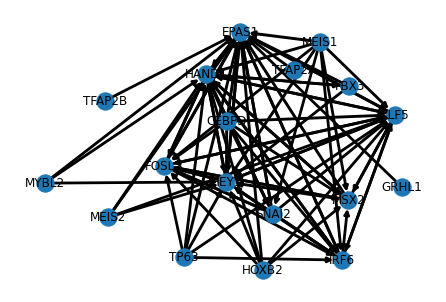

In [144]:
#calculate the position of the nodes and edges
pos = nx.spring_layout(GRN, k=1, iterations=20)
nx.draw(GRN, pos, with_labels = True, width = df_edges.width)

In [145]:
#set color for network and node sizes
df_nodes = pd.DataFrame(GRN.nodes, columns = ['nodes'])
df_nodes['color'] = 'NaN'
 
for i, row in df_nodes.iterrows():
    if row.nodes in Cluster1:
        color = '#7f7fff'  #blue
        df_nodes.at[i, 'color'] = color
    elif row.nodes in Cluster2:
        color = '#FF0000'  #red
        df_nodes.at[i, 'color'] = color
    elif row.nodes in Cluster3:
        color = '#FFFF00'  #yellow
        df_nodes.at[i, 'color'] = color    
    elif row.nodes in Cluster4:
        color = '#00FF00'  #green
        df_nodes.at[i, 'color'] = color
    elif row.nodes in Cluster5:
        color = '#FFC0CB'  #pink
        df_nodes.at[i, 'color'] = color
    elif row.nodes in Cluster6:
        color = '#964B00'  #brown
        df_nodes.at[i, 'color'] = color
    elif row.nodes in Cluster7:
        color = '#FF5F1F'  #orange
        df_nodes.at[i, 'color'] = color

In [146]:
#set node size based on the out degree and z-score normalize it
df_nodes['node_size'] = df_nodes['nodes'].map(GRN.out_degree())*100
df_nodes['node_size'] = df_nodes['node_size'].replace(0,200)

In [149]:
#save plot
my_dpi=96
plt.figure(figsize=(10.000, 10.000), dpi=100)
nx.draw_networkx(GRN, 
                 pos,
                 node_color=df_nodes.color,
                 node_size = df_nodes.node_size, 
                 with_labels=True, 
                 width = df_edges.width, 
                 font_size = 10,
                 arrows = True,
                 arrowstyle='-|>, head_width = 0.8, head_length= 0.8'
#                  arrowsize = 100
                )
output_temp = ['/scratch/bacint/jdeleuw/ananse/analysis/GRN/comparisons/Day43_', names, '_GRN.png']
output_path = ''.join(output_temp)
plt.savefig(output_path, dpi=1000)
plt.clf()

<Figure size 1000x1000 with 0 Axes>